In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

#### ZAD 1, 2, 3

Wczytanie danych

In [40]:
df = pd.read_csv("CO2.csv")

Konwersja indeksu do odpowiedniego miesiaca

In [41]:
df['date'] = pd.to_datetime(dict(year=df['Year'], month=df['Month'], day=1))
df.set_index('date', inplace=True)

Interpolacja danych brakujacych

In [42]:
co2 = df['Carbon Dioxide (ppm)']
co2 = co2.asfreq('MS').interpolate(limit_direction='both')

Deklaracja periods i seasonal_degrees do testow

In [44]:
periods = [12, 24, 36]
seasonal_degrees = [0, 1, 2]
results = []

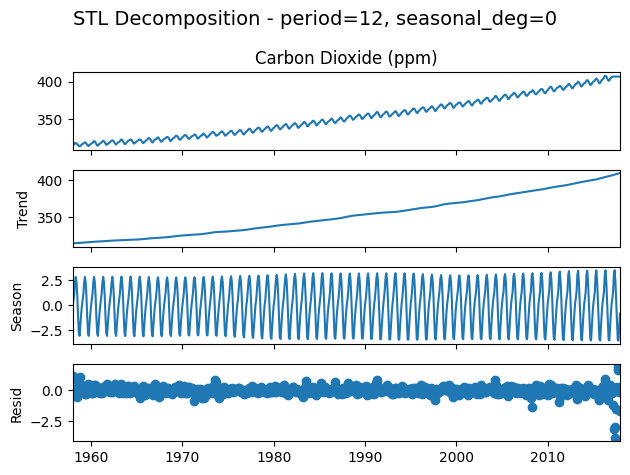

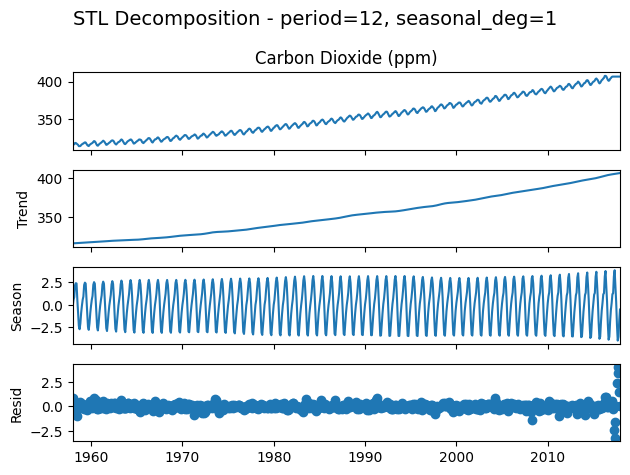

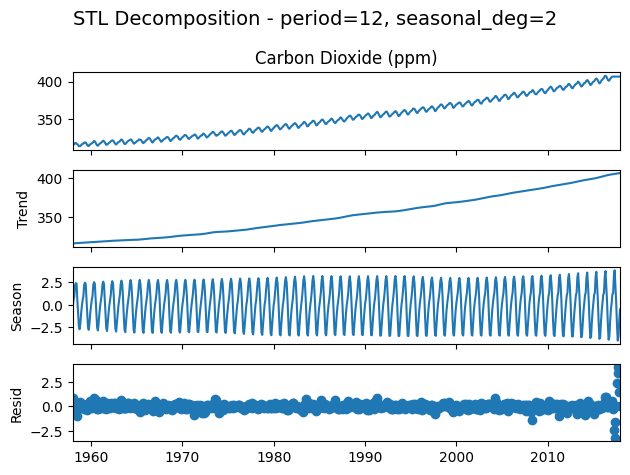

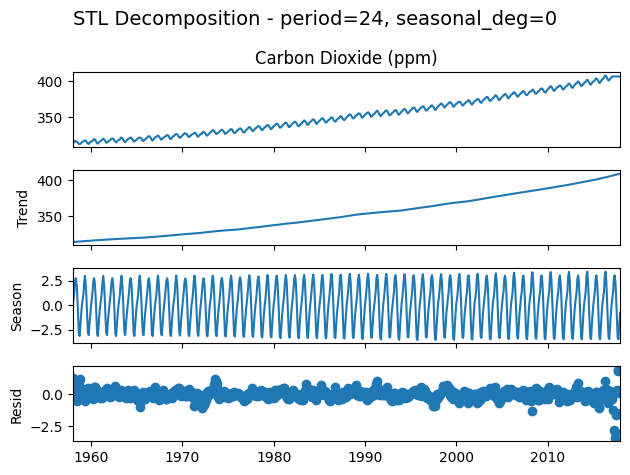

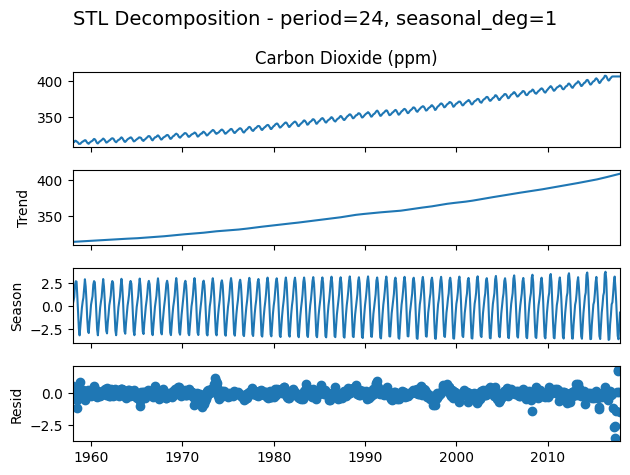

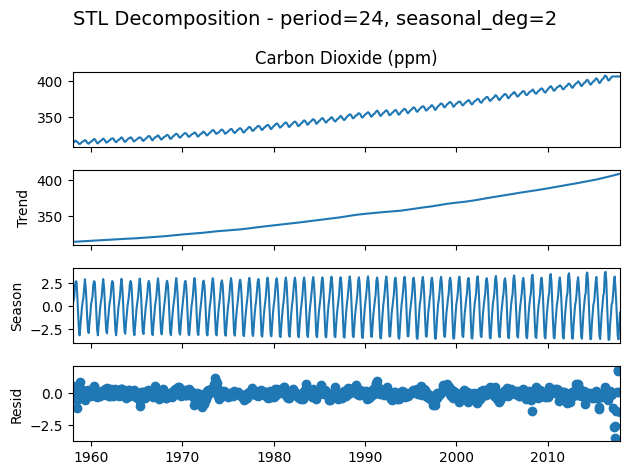

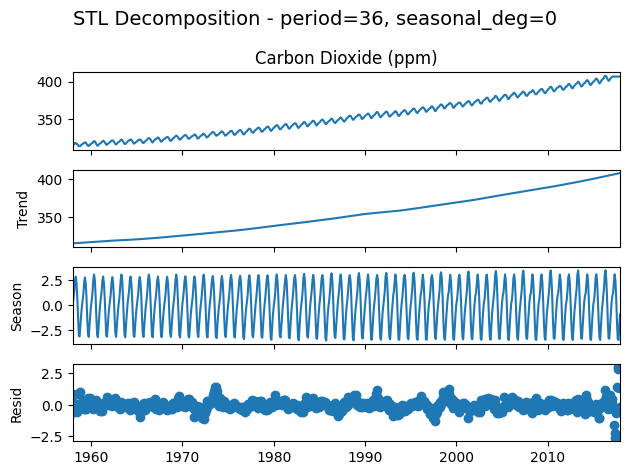

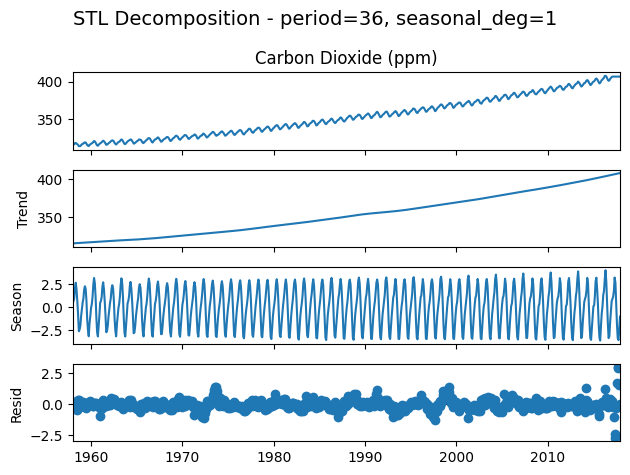

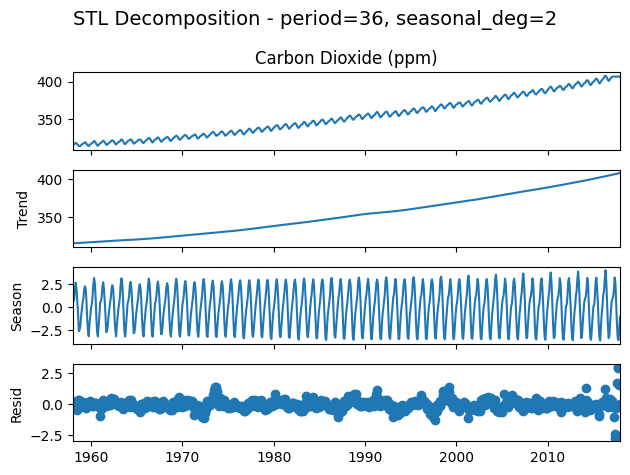

Magnitudy - podsumowanie:

   period  seasonal_deg  seasonality_magnitude  trend_magnitude  \
0      12             0               2.105817        26.915185   
1      12             1               2.102493        26.861752   
2      12             2               2.102493        26.861752   
3      24             0               2.106201        26.914933   
4      24             1               2.106212        26.907820   
5      24             2               2.106212        26.907820   
6      36             0               2.112025        26.869734   
7      36             1               2.094698        26.855215   
8      36             2               2.094698        26.855215   

   residual_magnitude  
0            0.359332  
1            0.367753  
2            0.367753  
3            0.388217  
4            0.377699  
5            0.377699  
6            0.421895  
7            0.414262  
8            0.414262  


In [45]:
for period in periods:
    for seasonal_deg in seasonal_degrees:
        stl = STL(co2, period=period, seasonal=13, seasonal_deg=seasonal_deg, robust=True)
        res = stl.fit()
        results.append({
            'period': period,
            'seasonal_deg': seasonal_deg,
            'seasonality_magnitude': res.seasonal.std(),
            'trend_magnitude': res.trend.std(),
            'residual_magnitude': res.resid.std()
        })
        res.plot()
        plt.suptitle(f'STL Decomposition - period={period}, seasonal_deg={seasonal_deg}', fontsize=14)
        plt.tight_layout()
        plt.show()

summary_df = pd.DataFrame(results)
print("Magnitudy - podsumowanie:\n")
print(summary_df)


#### ZAD 4, 5 

Analiza została przeprowadzona dla trzech wartości period (12, 24, 36) oraz trzech stopni wygładzania sezonowego seasonal_deg (0, 1, 2). Ocenie poddano magnitudy trzech komponentów: sezonowość, trend i rezyduła (szum).

1. Sezonowość - analiza:
- Wartości magnitudy sezonowej są bardzo zbliżone niezależnie od stopnia wielomianu (seasonal_deg), co sugeruje, że wybór stopnia wygładzania sezonowego ma niewielki wpływ na ocenę sezonowości
- Wraz ze wzrostem period do 36, pojawia się niewielki wzrost sezonowości przy seasonal_deg=0 (do 2.112), a spadek przy wyższych stopniach (2.094)
- Najwyższą wartość sezonowości uzyskano dla period=36 i seasonal_deg=0

2. Trend - analiza:
- Trend wykazuje stabilność — wartości magnitudy oscylują w wąskim zakresie od 26.85 do 26.91
- Różnice pomiędzy stopniami seasonal_deg są minimalne, co wskazuje, że składnik trendu jest niewrażliwy na zmianę parametrów sezonowości w tym zakresie

3. Reszty, rezyduła - analiza:
- Magnituda reszt rośnie wraz ze wzrostem period, np. z 0.36 (dla period=12) do 0.42 (dla period=36, deg=0)
- Minimalne wartości uzyskano dla period=12, największe dla period=36, co sugeruje, że dłuższe okresy powodują mniej precyzyjne dopasowanie modelu, zwiększając resztę
- Wyższy seasonal_deg nie zawsze zmniejsza resztę — trend jest nieliniowy.

Wnioski:
- Parametr period ma większy wpływ na wyniki dekompozycji niż seasonal_deg
- Składniki sezonowy i trendowy są stabilne, podczas gdy składnik resztowy (residual) zmienia się bardziej zauważalnie, co powinno być brane pod uwagę przy doborze parametrów
- Użycie większego period może pogorszyć dopasowanie modelu (większe reszty), nawet jeśli sezonowość wydaje się lepiej uchwycona
- Zmiana seasonal_deg z 0 do 2 nie wpływa istotnie na magnitudy sezonowości i trendu, ale może mieć umiarkowany wpływ na reszty

Zalecam metodę STL, gdyż:
- STL umożliwia dopasowanie poziomu wygładzania zarówno trendu, jak i sezonowości przez dobór parametrów (seasonal, trend, seasonal_deg), co pozwala lepiej dostosować dekompozycję do charakterystyki danyc
- Jest bardziej odporna na szum i outliery, co może prowadzić do bardziej stabilnych i wiarygodnych cech wejściowych w modelach ML
- Cechy uzyskane dzięki STL (np. komponent trendowy, sezonowy i resztowy) można bezpośrednio wykorzystać jako oddzielne zmienne w modelach predykcyjnych
- W przeciwieństwie do klasycznej dekompozycji, która wymaga pełnych i regularnych danych, STL radzi sobie lepiej z danymi z lukami (po interpolacji) i nietypowymi strukturami sezonowymi

Moim zdaniem najlepsze wyniki dekompozycji STL uzyskano przy następujących ustawieniach (niewielkie reszty, stabilny trend, dobrze uchwycona sezonowość):
- period = 12
- seasonal = 13 
- seasonal_deg = 1

Trend wykazuje stały, wyraźny wzrost, co sugeruje, że poziom CO₂ systematycznie się zwiększa w analizowanym okresie. To potwierdza zjawisko narastającej emisji CO2 w skali globalnej.

Składnik sezonowy reprezentuje cykliczne zmiany w poziomie CO2 występujące co 12 miesięcy. Ma on niewielką, ale zauważalną amplitudę, ok. 2.1 ppm.

Magnituda reszt (0.3677) jest niska, co oznacza, że większość struktury danych została dobrze wyjaśniona przez trend i sezonowość.